In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [14]:
from typing import Tuple, List, Dict


def get_simulation_files() -> Tuple[
    Dict[str, List[str]],
    Dict[str, List[str]],
    Dict[str, List[str]],
    Dict[str, List[str]],
]:
    def add_file(dict: Dict, key: str, value: str) -> None:
        if key in dict:
            dict[key].append(value)
        else:
            dict[key] = [value]

    avg_degree, degree_distribution, giant_component, sizes_of_components = (
        {},
        {},
        {},
        {},
    )
    for file in os.listdir():
        if file.endswith(".txt"):
            try:
                [filename, _] = file.split("(")
                if filename.endswith("avg_degree"):
                    add_file(avg_degree, filename, file)
                elif filename.endswith("degree_distribution"):
                    add_file(degree_distribution, filename, file)
                elif filename.endswith("giant_component"):
                    add_file(giant_component, filename, file)
                elif filename.endswith("sizes_of_components"):
                    add_file(sizes_of_components, filename, file)
            except:
                continue

    return avg_degree, degree_distribution, giant_component, sizes_of_components


def process_prefix(file_name: str) -> Tuple[int, int, float, float]:
    def get_fraction(fraction_str: str) -> float:
        [num, den] = fraction_str.split("d")
        return float(num) / float(den)

    file_info = file_name.split("_")
    num_nodes = int(file_info[1])
    steps = int(file_info[3])
    alpha = get_fraction(file_info[5])
    r = get_fraction(file_info[7])

    return num_nodes, steps, alpha, r


## Plot \<K\>(t)

In [15]:
from typing import Callable

import scipy.special as sc


def pk_builder(alpha, r) -> Callable[[float, float], float]:
    def c(t):
        return alpha / r * (1 - np.exp(-r * t))

    def Q(k, c):
        return sc.gammaincc(k, c)

    return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k) 


def expected_k_builder(alpha, r) -> Callable[[float], float]:
    alphadr = alpha / r

    return lambda t: alphadr / 2 * (1 - np.exp(-2 * r * t))


In [16]:
pk_calculator = pk_builder(alpha=1, r=0.5)
pk_calculator(100, 2)

1.6968366103994441e-149

In [17]:
def plot_avg_degree(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])
    min_step = float(min_step)

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values

    expected_k = expected_k_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 75
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.xlabel("Time")
    plt.ylabel("Average Degree")
    plt.errorbar(x_values[::skip_size], mean[::skip_size], yerr=std[::skip_size], fmt="o", mfc="none", color="black")
    plt.plot(x_values, list(map(expected_k, x_values)),color="red")
    plt.legend(
        [
            "Theory - alpha = " + str(alpha) + ", r = " + str(r),
            "Simul. - alpha = " + str(alpha) + ", r = " + str(r),
        ]
    )
    plt.show()

10000 50000 1.0 0.5


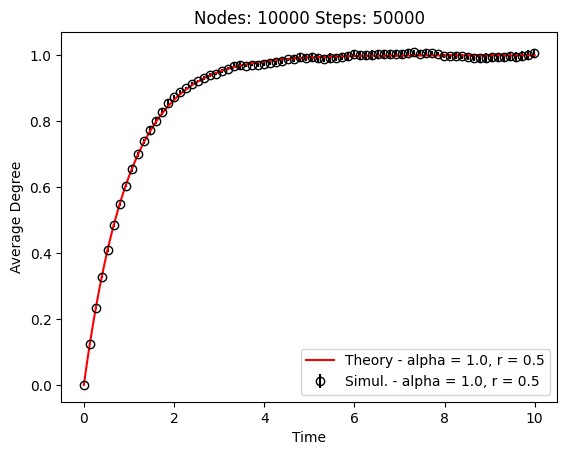

100 1000 2.0 0.5


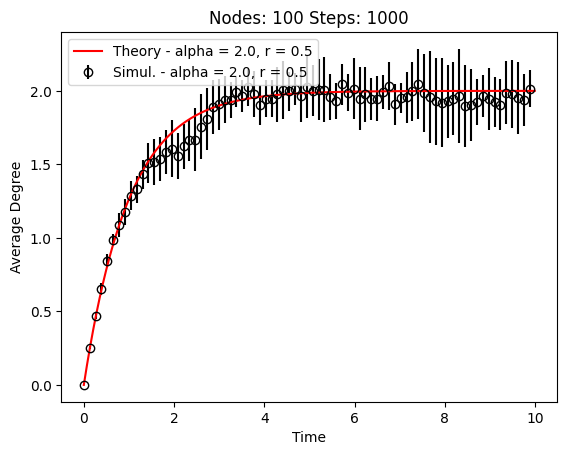

25000 50000 1.0 0.5


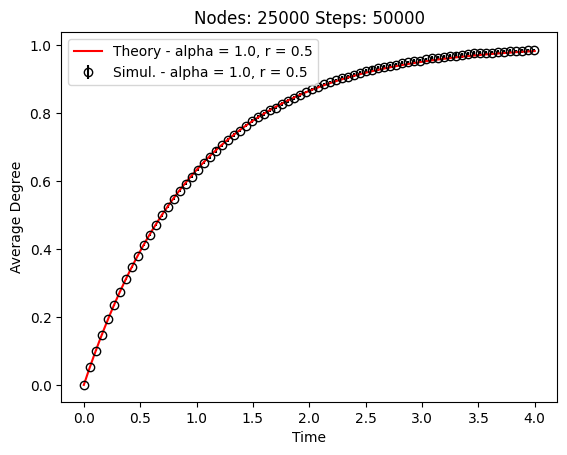

50000 50000 1.0 0.5


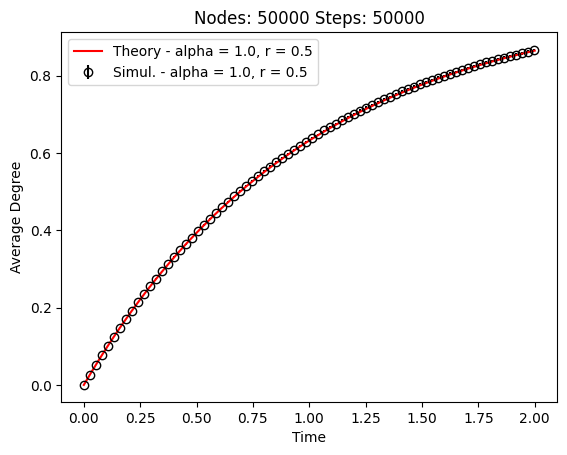

In [18]:
for prefix, file_list in get_simulation_files()[0].items():
    plot_avg_degree(prefix=prefix, file_list=file_list)


In [5]:
def calculate_mean(values: List[List[Dict[int, float]]]):

    num_files = len(values)
    num_steps = len(values[0])
    print(num_steps)

    def process(step_info: Dict[int, float], step: Dict[int, float]) -> None:
         for k, v in step_info.items():
            if not k in step:
                step[k] = float(v)/num_files
            else:
                 step[k] += float(v)/num_files

    series: List[Dict[int, float]] = []

    for i in range(0, num_steps):
            step = {}
            for file_data in values:
                process(file_data[i], step)
            series.append(step)
    
    series_as_dict = {}
    for idx, serie in enumerate(series):
        for key, value in serie.items():
            if not key in series_as_dict:
                series_as_dict[key] = np.zeros(num_steps)
            series_as_dict[key][idx] = value

    return series_as_dict

In [6]:
def plot_degree_distribution(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    def build_dict(row):
        unique, counts = np.unique(row, return_counts=True)
        return dict(zip(unique, counts))

    values = []
    for file in file_list:
        df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
        counts = list(map(lambda r: build_dict(r), df.values))
        values.append(counts)

    series = calculate_mean(values)

    min_step: float = 1

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    pk = pk_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 75

    for k, pk_values in series.items():
        if k < 6:
            plt.yscale("log")
            plt.plot(
                x_values,
                list(map(lambda x: pk(k, x), x_values)),
                label=str(k) + " - theory",
                color="red",
            )
            plt.plot(
                x_values[::skip_size],
                pk_values[::skip_size] / float(num_nodes),
                label=str(k) + " - simulation",
                marker="o",
                mfc="none",
                color="black",
                linestyle="None",
            )
    plt.ylim(0.0001, 1)

    plt.xlabel("Time")
    plt.ylabel("Degree Distribution")
    plt.legend()
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.show()


10000 10000 1.0 0.5
10000


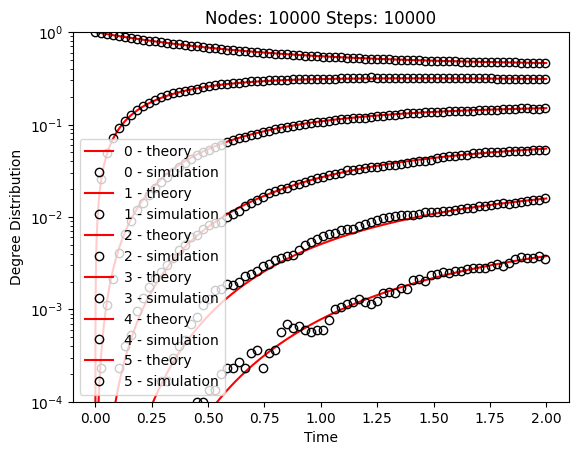

100 10000 2.0 2.5
6001


ValueError: x and y must have same first dimension, but have shapes (76,) and (46,)

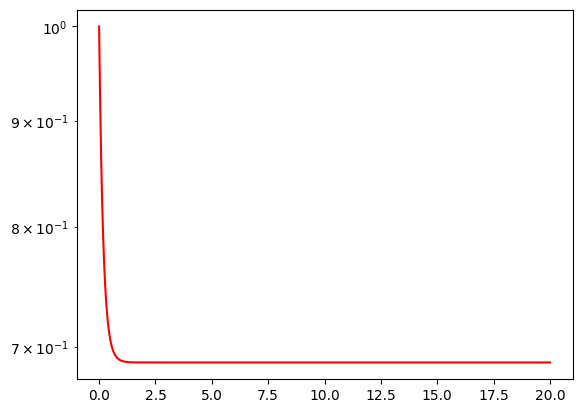

In [34]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
    plot_degree_distribution(prefix=prefix, file_list=file_list)


In [7]:
def calculate_u(expected_k_t: float, pk_t: List[float], num_nodes: int) -> float:

    diff = 0.1  # It just needs to be better than the acceptance threshold
    u = 0.5  # Initial value
    sum_u = 0
    while abs(diff) > 1e-6:
        sum_u = 0
        sum_du = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
            sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
        diff = u - sum_u / expected_k_t
        u = u - (u - sum_u / expected_k_t) / (1 - sum_du / expected_k_t)
    return u


def generating_function(alpha: float, r: float, z: float, t: float) -> float:
    def G(x):
        return (x - r / alpha) * np.exp(alpha / r * (x - 1))

    return (
        1 / (1 - z) * (np.exp(alpha * z / r) * G((1 - z) * np.exp(-r * t)) + r / alpha)
    )


def der_generating_function(alpha: float, r: float, z: float, t: float) -> float:
    def G(x):
        return (x - r / alpha) * np.exp(alpha / r * (x - 1))

    def dG(x):
        return alpha / r * x * np.exp(alpha / r * (x - 1))

    return 1 / ((1 - z) ** 2) * (
        np.exp(alpha * z / r) * G((1 - z) * np.exp(-r * t)) + r / alpha
    ) + 1 / (1 - z) * (
        alpha / r * np.exp(alpha * z / r) * G((1 - z) * np.exp(-r * t))
        - np.exp(alpha * z / r) * dG((1 - z) * np.exp(-r * t)) * np.exp(-r * t)
    )


In [8]:
def giant_component_builder(
    alpha: float, r: float, num_nodes: int
) -> Callable[[float], float]:
    # We can restrict infinity to (num_nodes - 1) as pk k>= num_nodes - 1 = 0
    print(alpha, r, num_nodes)

    expected_k = expected_k_builder(alpha=alpha, r=r)
    pk = pk_builder(alpha=alpha, r=r)

    def s(t: float) -> float:
        expected_k_t = expected_k(t)
        pk_t = [pk(k, t) for k in range(0, num_nodes // 2)]

        u_t = calculate_u(expected_k_t, pk_t)
        return 1 - generating_function(alpha, r, u_t, t)

    def calculate_u(expected_k_t: float, pk_t: List[float]) -> float:

        diff = 0.1  # It just needs to be better than the acceptance threshold
        u = 0.5  # Initial value
        while abs(diff) > 1e-3:
            sum_u = 0
            sum_du = 0
            for k in range(1, num_nodes // 2):
                sum_u += k * pk_t[k] * (u ** (k - 1))
                sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
            diff = u - sum_u / expected_k_t
            u = u - (u - sum_u / expected_k_t) / (1 - sum_du / expected_k_t)
        return u

    return lambda t: 0 if t < 0.02 else s(t)


In [26]:
def plot_giant_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    avg_size = np.zeros(num_steps)
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            print(len(lines))
            for step, line in enumerate(lines):
                val = int(line)
                avg_size[step] += val
    avg_size /= float(len(file_list) * num_nodes)
    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))
    
    x_theory_values : np.ndarray
    y_theory_values : np.ndarray

    with open("Curves_TimeDep_alpha{:.3f}_r{:.3f}.txt".format(alpha, r)) as f:
        next(f)
        lines = f.readlines()
        x_theory_values = np.zeros(len(lines))
        y_theory_values = np.zeros(len(lines))
        for i, line in enumerate(lines):
            x_theory_values[i] = float(line.split()[0])
            y_theory_values[i] = float(line.split()[1])
    

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))

    #cut x_theory_values and y_theory_values to match x_values by value not by length
    x_theory_values = x_theory_values[x_theory_values <= x_values[-1]]
    y_theory_values = y_theory_values[:len(x_theory_values)]

    skip_size: int = num_steps // 75
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.xlabel("Time")
    plt.ylabel("Giant component size")
    plt.plot(x_theory_values, y_theory_values, label="Theory", color="red")
    plt.scatter(
        x_values[::skip_size],
        avg_size[::skip_size],
        facecolors="none",
        color="black",
        label="Simulation",
    )
    plt.legend([
            "Theory - alpha = " + str(alpha) + ", r = " + str(r),
            "Simul. - alpha = " + str(alpha) + ", r = " + str(r),
        ])
    plt.show()


10000 20000 2.0 0.5
20000
20000
20000


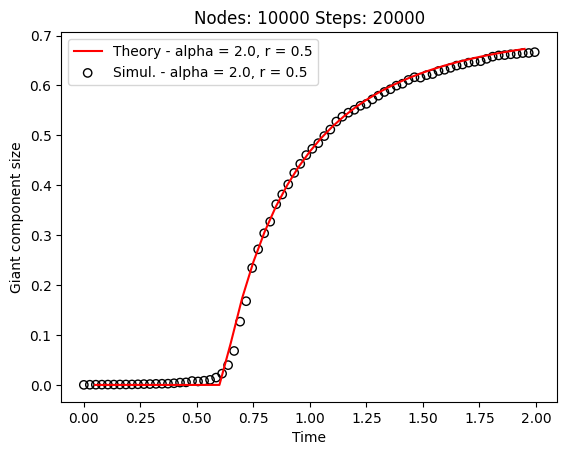

15000 35000 1.0 0.5
35000
35000
35000
35000
35000
35000
35000
35000
35000
35000


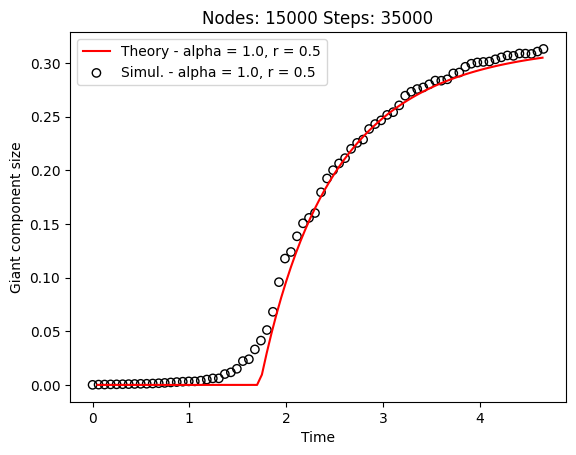

In [27]:
files = get_simulation_files()[2]
for prefix, file_list in files.items():
    plot_giant_component(prefix=prefix, file_list=file_list)


In [18]:
def first_passage_stats(column):
    max_degree_reached = 0
    step_when_degree_reached = np.zeros(1, dtype=np.int8)
    for step, degree in enumerate(column):
        if degree > max_degree_reached:
            step_when_degree_reached = np.append((step_when_degree_reached), step)
            max_degree_reached = degree
    return step_when_degree_reached


def p(distribution, first_passage, k, step):
    count = 0
    for node_idx in range(len(first_passage)):
        count += (
            step < first_passage[node_idx][k + 1] and distribution[node_idx][step] == k
        )
    return count


# Theory
def qk_t(k_star: int, t_values, alpha: float, r: float):
    def compute_step(qk, ak: float, AT: float):
        next_qk = np.zeros(k_star, dtype=np.float64)

        next_qk[0] = (
            qk[0] + (-(alpha + r) * qk[0] + r * qk[1] + r * qk[1] + r * (1 - ak)) * AT
        )

        for k in range(1, k_star - 1):
            next_qk[k] = (
                qk[k]
                + (
                    alpha * qk[k - 1]
                    - (alpha + r) * qk[k]
                    + r * (k + 1) * qk[k + 1]
                    - r * k * qk[k]
                )
                * AT
            )

        next_qk[k_star - 1] = (
            qk[k_star - 1]
            + (
                alpha * qk[k_star - 2]
                - (alpha + r) * qk[k_star - 1]
                - r * (k_star - 1) * qk[k_star - 1]
            )
            * AT
        )

        ak = ak + (alpha * qk[k_star - 1]) * AT

        return next_qk, ak

    qk = np.zeros(k_star, dtype=np.float64)
    qk[0] = 1
    ak: float = 0
    qk_t = []
    qk_t.append(qk)
    for i in range(0, len(t_values) - 1):
        qk, ak = compute_step(qk, ak, t_values[i + 1] - t_values[i])
        qk_t.append(qk)
    return np.array(qk_t)[:, -1]


def smooth_data(pk_plot):
    idx = pk_plot.size // 100
    while np.count_nonzero(pk_plot[idx : idx + 10] == 0) < 2:
        idx += 10
    pk_plot[idx:] = 0
    return pk_plot


In [23]:
def plot_first_passage_prob(file: str) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(file)
    print(num_nodes, num_steps, alpha, r)

    df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
    first_time = df.apply(first_passage_stats, axis=0)
    lowest_deg = 1000
    for serie in first_time:
        lowest_deg = min(lowest_deg, len(serie))
    print(lowest_deg)

    first_time = first_time.apply(lambda arr: np.resize(arr, lowest_deg + 1))

    min_step: float = 1

    with open(file) as f:
        min_step = float(f.readline().strip("\n"))

    k_values = list(range(3, lowest_deg - 2))

    t_values = list(range(0, num_steps, 10))
    pk_plots = []

    for k in k_values:
        pk_plots.append(np.asarray([p(df, first_time, k, t) for t in t_values]))

    pk_plots = list(map(smooth_data, pk_plots))

    plt.yscale("log")
    plt.xscale("log")

    for idx, pk_plot in enumerate(pk_plots):
        plt.plot(
            list(map(lambda t: t * min_step / float(num_nodes), t_values)),
            list(map(lambda x: x / float(num_nodes), pk_plot)),
            label=str(k_values[idx] + 1) + " - simulation",
        )

    t_values = np.linspace(0, 1e3, 10000) * min_step / float(num_nodes)
    for k in k_values:
        plt.plot(
            t_values,
            qk_t(k_star=k + 1, t_values=t_values, alpha=2, r=0.5),
            label=str(k + 1) + " - numerical solution",
        )
    
    plt.xlim(1e-2, 1e2)
    plt.ylim(1e-5, 1)

    plt.legend()
    plt.title(
        "Nodes: "
        + str(num_nodes)
        + " Steps: "
        + str(num_steps)
        + "alpha: "
        + str(alpha)
        + ", r: "
        + str(r)
    )
    plt.xlabel("Time")
    plt.ylabel("First passage probability")
    plt.show()
# don't comment

10000 10000 1.0 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1


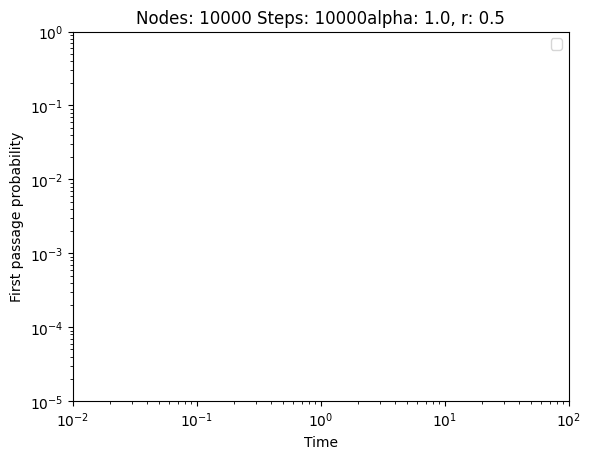

10000 10000 1.0 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1


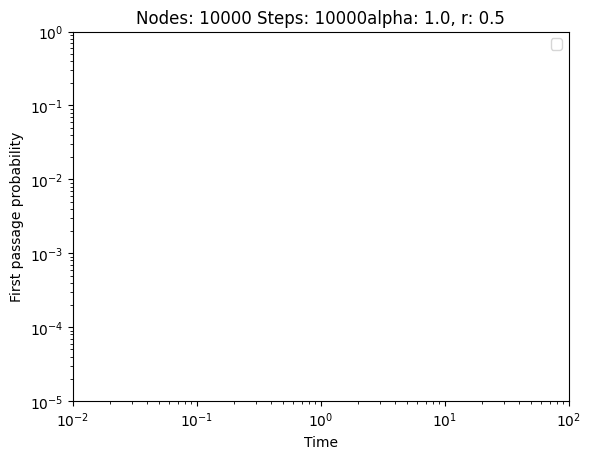

10000 10000 1.0 0.5
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


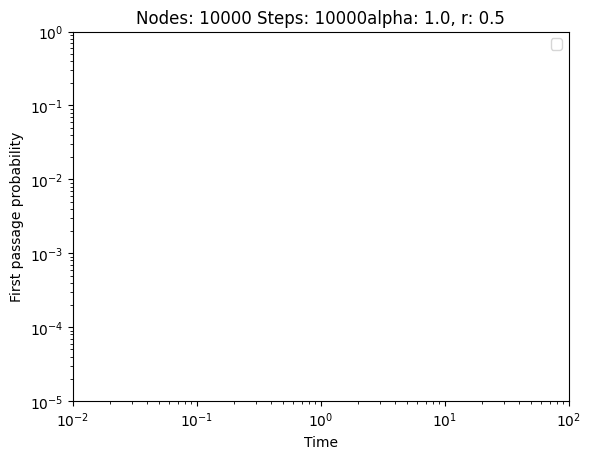

100 10000 2.0 2.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


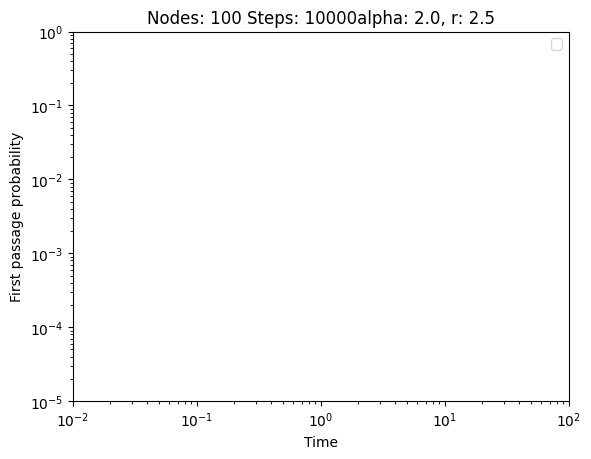

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100 200 1.0 0.5
1


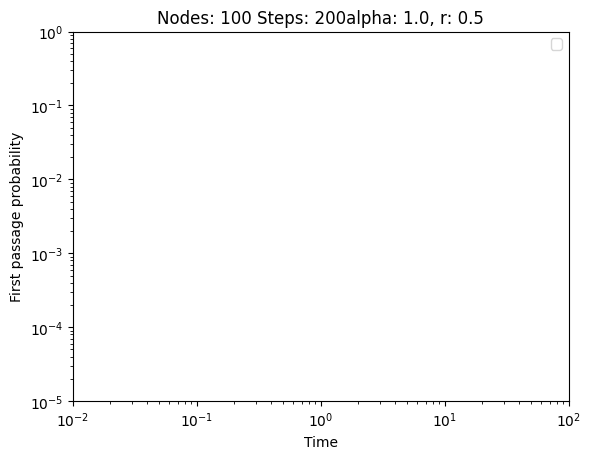

100 50000 2.0 0.5
9


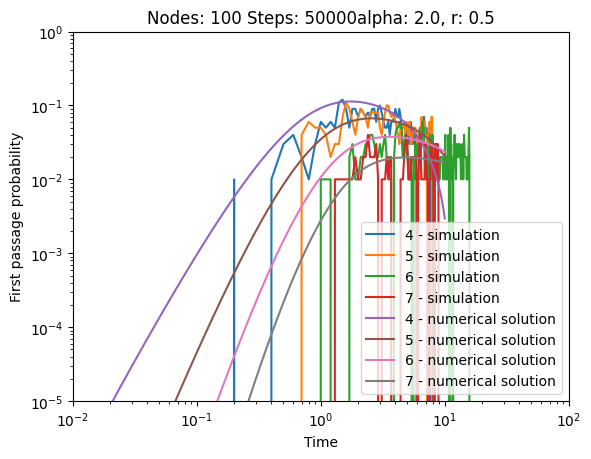

100 50000 2.0 0.2
13


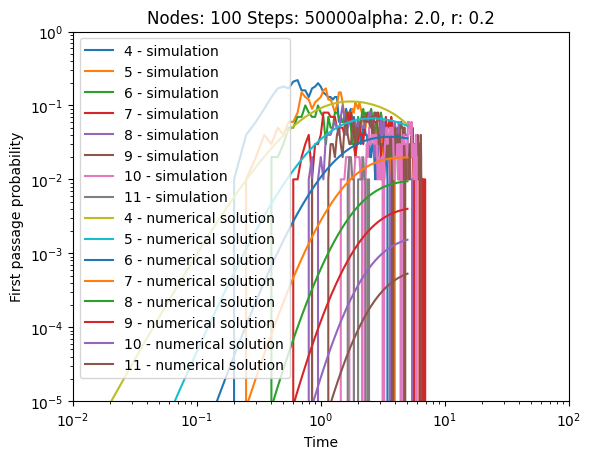

5000 3000 1.0 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1


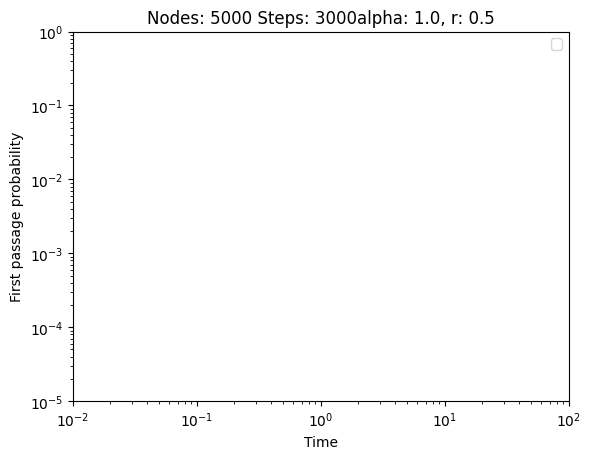

5000 3000 1.0 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1


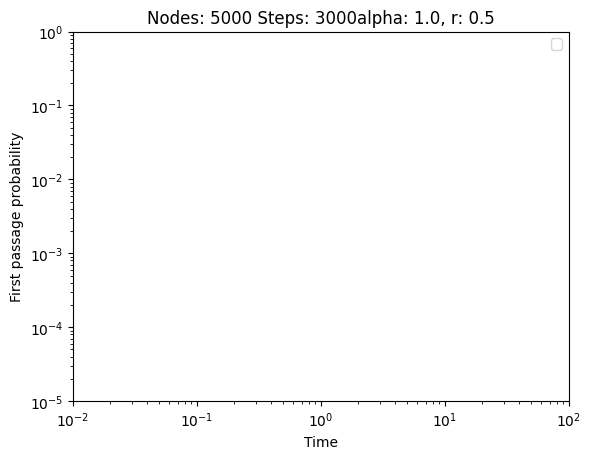

5000 3000 1.0 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1


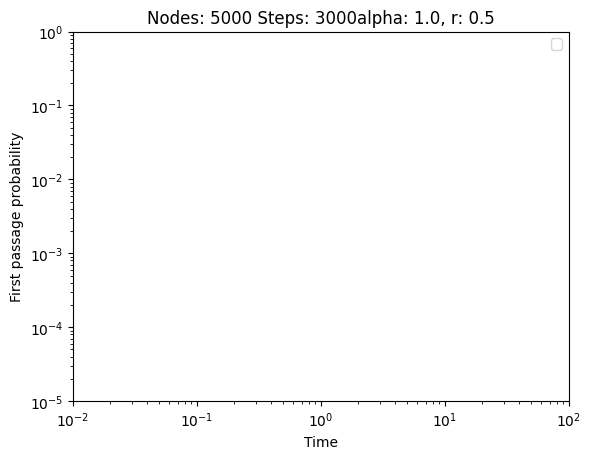

In [25]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
        num_nodes, num_steps, _, _ = process_prefix(prefix)
        #if num_nodes == 100 and num_steps > 10000:
        for file in file_list:
            plot_first_passage_prob(file)

In [26]:
def plot_first_passage(file: str) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(file)
    print(num_nodes, num_steps, alpha, r)

    df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
    first_time = df.apply(first_passage_stats, axis=0)
    lowest_deg = 1000
    for serie in first_time:
        lowest_deg = min(lowest_deg, len(serie))
    print(lowest_deg)

    min_step: float = 1

    with open(file) as f:
        min_step = float(f.readline().strip("\n"))

    sized_first_time = first_time.apply(lambda arr: np.resize(arr, lowest_deg))
    avg_step = sized_first_time.sum() / 100
    times = avg_step * min_step / (float(num_nodes))

    plt.yscale("log")
    plt.plot(times, marker="o", linestyle="None")
    plt.title(
        "Nodes: "
        + str(num_nodes)
        + " Steps: "
        + str(num_steps)
        + "alpha: "
        + str(alpha)
        + ", r: "
        + str(r)
    )
    plt.show()
# forget

100 10000 2.0 2.5
3


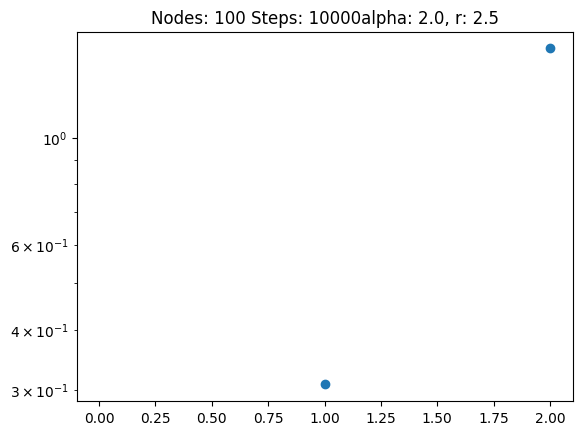

100 50000 2.0 0.5
9


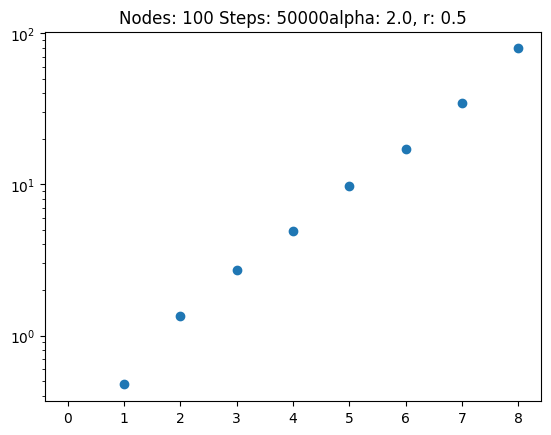

100 50000 2.0 0.2
13


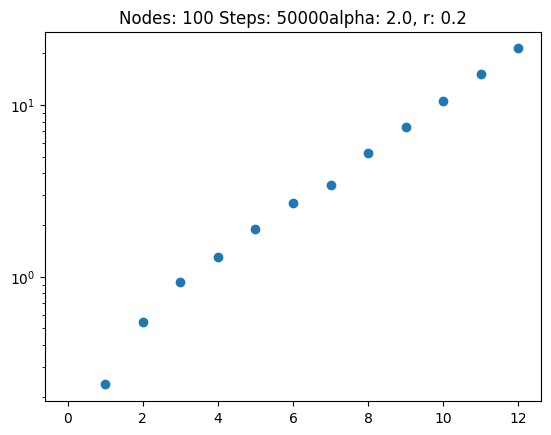

In [27]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
        num_nodes, num_steps, _, _ = process_prefix(prefix)
        if num_nodes == 100 and num_steps > 5000:
            for file in file_list:
                plot_first_passage(file)

In [28]:
def remove_max_and_avg(nums):
    no_nulls = nums[~np.isnan(nums)]
    return (np.sum(no_nulls) - np.max(no_nulls)) / np.size(no_nulls)

def calculate_u(expected_k_t: float, pk_t: List[float], num_nodes) -> float:

    diff = 0.1  # It just needs to be better than the acceptance threshold
    u = 0.5  # Initial value
    sum_u = 0
    while abs(diff) > 1e-6:
        sum_u = 0
        sum_du = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
            sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
        diff = u - sum_u / expected_k_t
        u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
    return u

def expected_small_component_size(alpha, r, num_nodes,  t):

    expected_k_t = expected_k_builder(alpha=alpha, r=r)(t)
    pk = pk_builder(alpha=alpha, r=r)
    pk_t = [pk(k, t) for k in range(num_nodes)]

    u_t = calculate_u(expected_k_t=expected_k_t, pk_t=pk_t, num_nodes=num_nodes)

    S = 1 - generating_function(alpha, r, u_t, t)


    return 2 / (2 - (expected_k_t * u_t**2) / (1 - S))

In [33]:
def plot_avg_size_of_small_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    avg_small_sizes = np.zeros(num_steps)
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                sizes = np.fromstring(line, dtype=float, sep=" ")
                val = (np.sum(sizes) - np.max(sizes)) / (np.size(sizes) - 1)
                avg_small_sizes[step] += val
    avg_small_sizes /= len(file_list)
    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 100
    plt.title(
        "Nodes: "
        + str(num_nodes)
        + " Steps: "
        + str(num_steps)
        + "alpha: "
        + str(alpha)
        + ", r: "
        + str(r)
    )
    plt.xlabel("Time")
    plt.ylabel("Average size of small component")
    x_theory_values = np.linspace(0, x_values[-1], 100)
    plt.errorbar(x_values[::skip_size], avg_small_sizes[::skip_size], fmt="o")
    plt.plot(x_theory_values, list(map(lambda t: expected_small_component_size(alpha, r, num_nodes, t), x_theory_values)))
    plt.show()


10000 30000 3.0 0.5


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\269438489.py:16: RuntimeWarning: invalid value encountered in scalar divide
  diff = u - sum_u / expected_k_t
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\269438489.py:17: RuntimeWarning: invalid value encountered in scalar divide
  u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\2309462788.py:13: RuntimeWarning: overflow encountered in scalar power
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\2309462788.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)


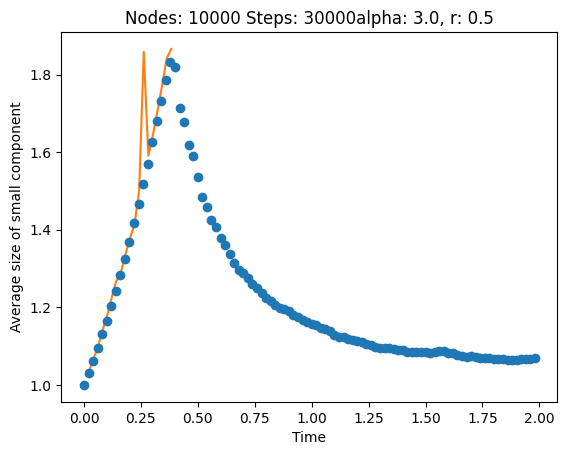

1000 2500 1.5 0.5


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\1816748630.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  1 / (1 - z) * (np.exp(alpha * z / r) * G((1 - z) * np.exp(-r * t)) + r / alpha)
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\1816748630.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  1 / (1 - z) * (np.exp(alpha * z / r) * G((1 - z) * np.exp(-r * t)) + r / alpha)


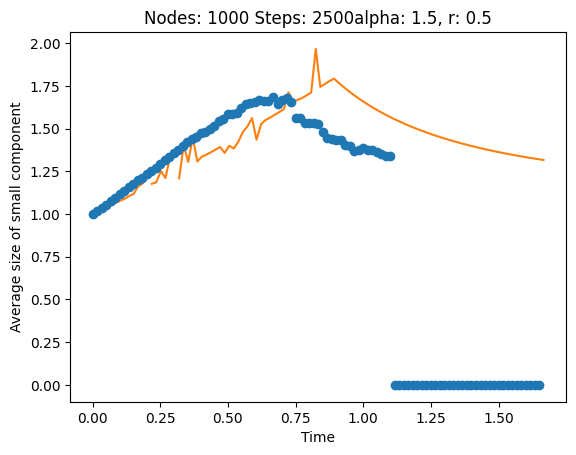

100 1000 2.0 0.5


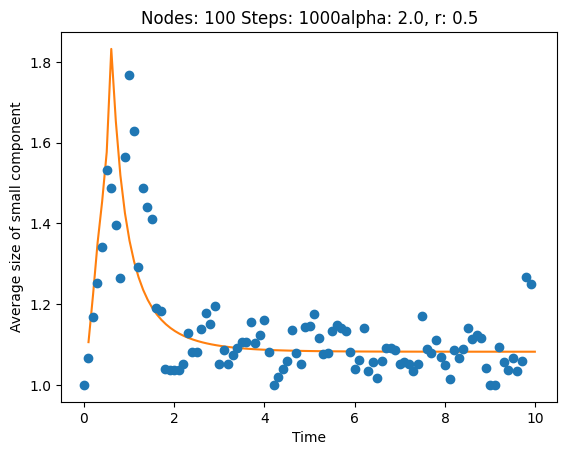

100 200 1.0 0.5


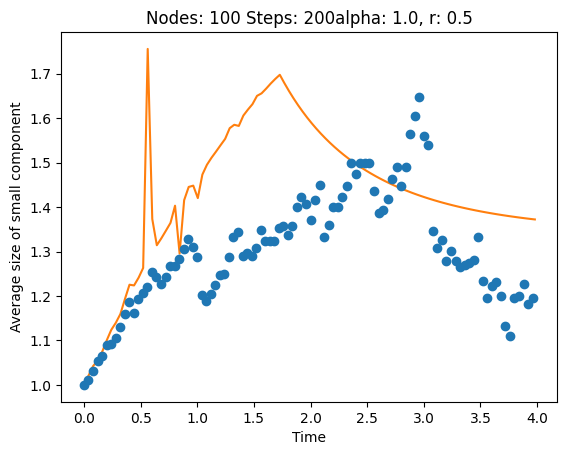

150 500 1.0 0.5


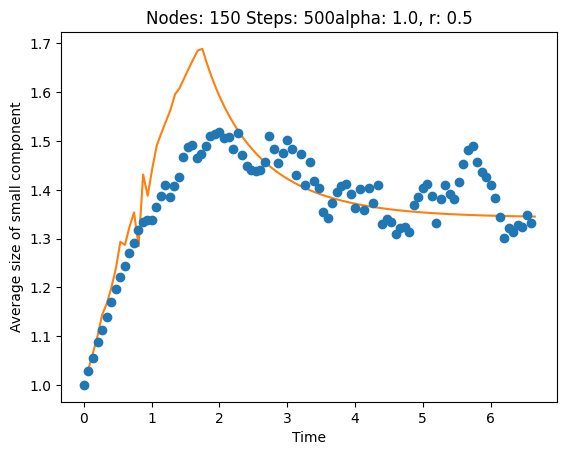

500 1500 2.0 0.25


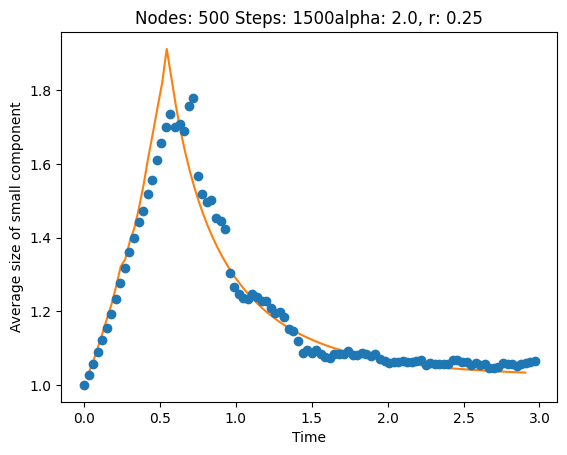

In [34]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    plot_avg_size_of_small_component(prefix=prefix, file_list=file_list)


100 1000 2.0 0.5


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\269438489.py:16: RuntimeWarning: invalid value encountered in scalar divide
  diff = u - sum_u / expected_k_t
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\269438489.py:17: RuntimeWarning: invalid value encountered in scalar divide
  u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)


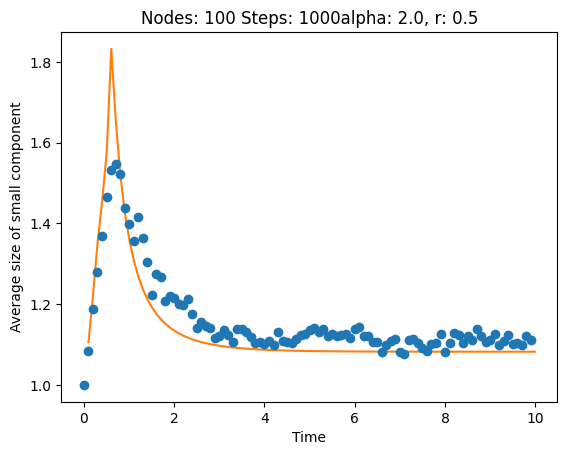

100 200 1.0 0.5


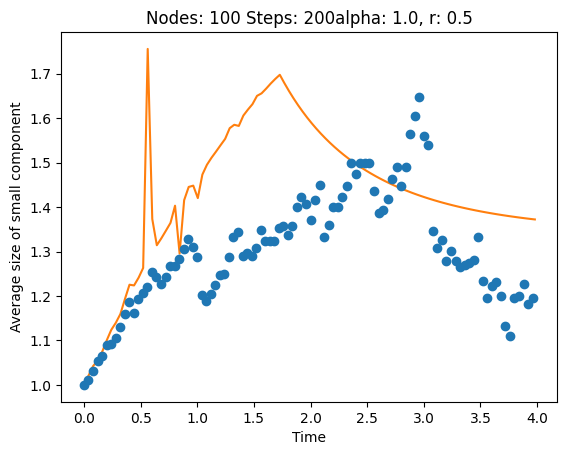

150 500 1.0 0.5


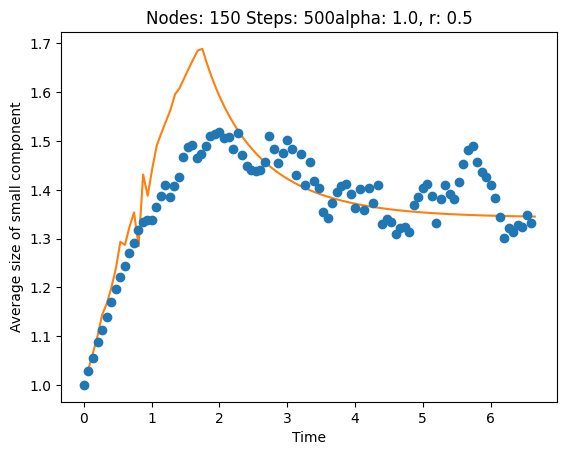

500 1500 2.0 0.25


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\2309462788.py:13: RuntimeWarning: overflow encountered in scalar power
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)
C:\Users\mique\AppData\Local\Temp\ipykernel_8420\2309462788.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)


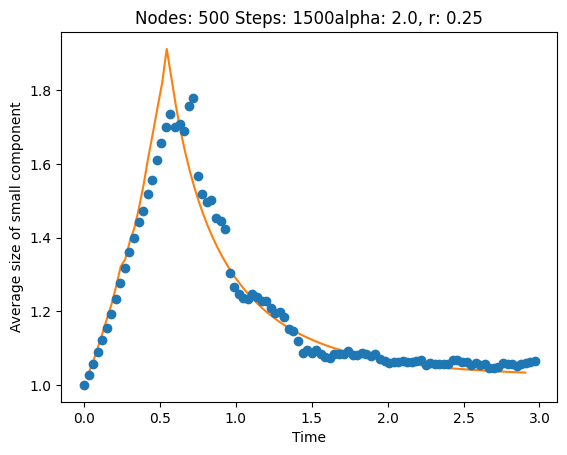

In [39]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    if not prefix.startswith("nodes_1000"):
        plot_avg_size_of_small_component(prefix=prefix, file_list=file_list)


In [42]:
def plot_component_distribution(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    component_distributions = [np.zeros(10)] * num_steps
    component_count = [0] * num_steps
    for file in file_list:
        print(file)
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                sizes = np.fromstring(line, dtype=int, sep=" ")
                counts = np.bincount(sizes, minlength=10)[:10]
                component_distributions[step] = np.add(
                    component_distributions[step], counts
                )
                component_count[step] += np.sum(sizes)

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    normalized_component_distributions = [component_distributions[step] / component_count[step] for step in range(num_steps)]

    plots = [ [normalized_component_distributions[step][component_size] for step in range(num_steps)] for component_size in range(2, 10, 2)]

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 100
    plt.title(
        "Nodes: "
        + str(num_nodes)
        + " Steps: "
        + str(num_steps)
        + "alpha: "
        + str(alpha)
        + ", r: "
        + str(r)
    )
    plt.xlabel("Time")
    plt.ylabel("Component size distribution")
    plt.yscale("log")
    for idx, plot in enumerate(plots):
        plt.scatter(x_values[::skip_size], plot[::skip_size], label = str(2 + idx*2))
    plt.legend()
    plt.show()
# add component size distribution vs component size (different lines different times)

10000 30000 3.0 0.5
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(0).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(1).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(2).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(3).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(4).txt


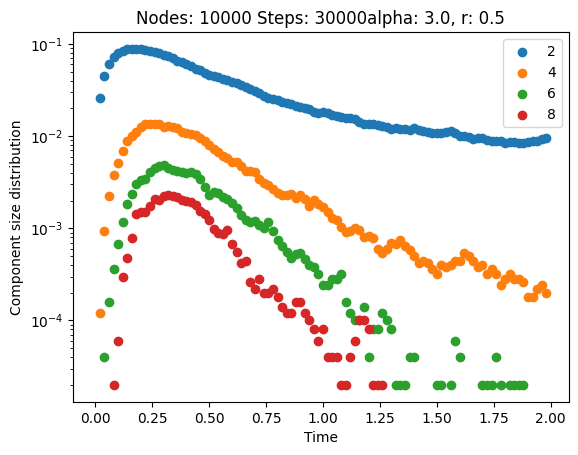

1000 2500 1.5 0.5
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(0).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(1).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(2).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(3).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(4).txt


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\306259520.py:27: RuntimeWarning: invalid value encountered in divide
  normalized_component_distributions = [component_distributions[step] / component_count[step] for step in range(num_steps)]


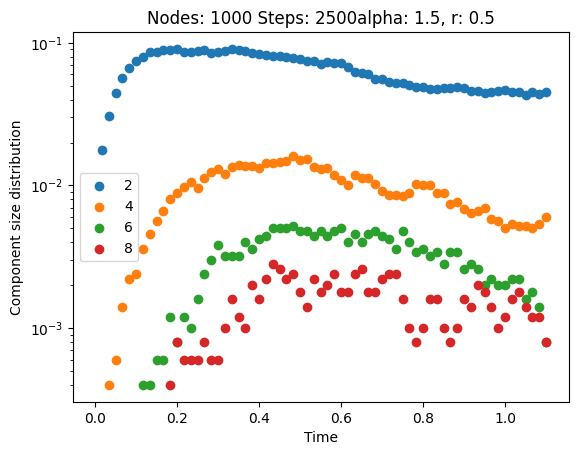

100 1000 2.0 0.5
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(0).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(1).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(10).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(11).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(12).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(13).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(14).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(15).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(16).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(17).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(18).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(19).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(2).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(3).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(4).txt
nodes_100_ste

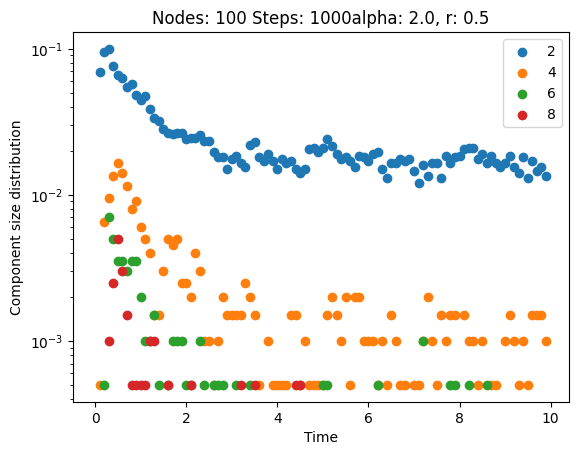

100 200 1.0 0.5
nodes_100_steps_200_alpha_1d1_r_1d2_sizes_of_components(0).txt


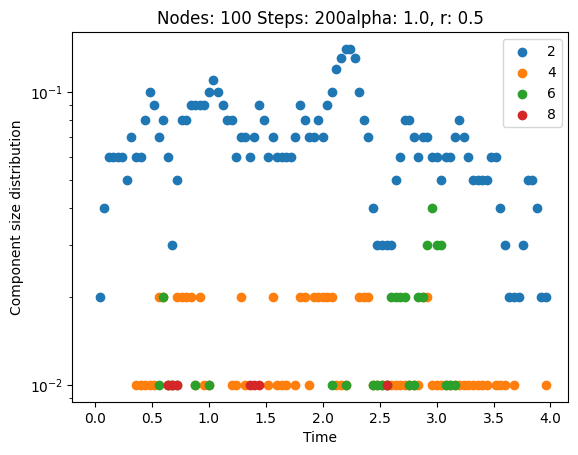

150 500 1.0 0.5
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(0).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(1).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(2).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(3).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(4).txt


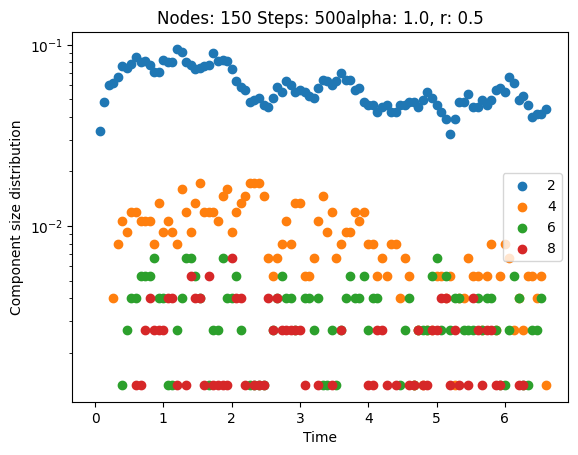

500 1500 2.0 0.25
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(0).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(1).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(2).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(3).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(4).txt


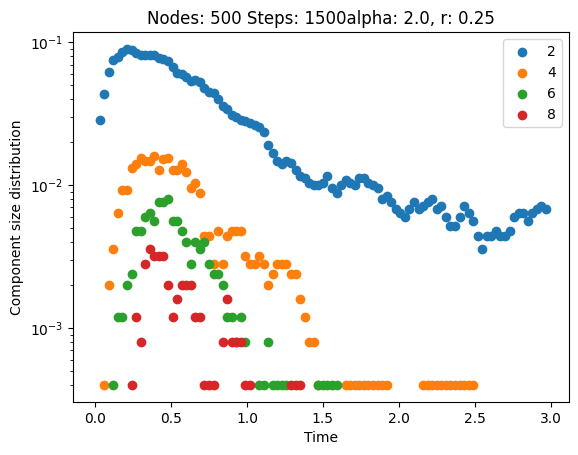

In [41]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    plot_component_distribution(prefix=prefix, file_list=file_list)


In [54]:
def plot_component_distribution_vs_size(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    component_distributions = [np.zeros(10)] * num_steps
    component_count = [0] * num_steps
    for file in file_list:
        print(file)
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                sizes = np.fromstring(line, dtype=int, sep=" ")
                counts = np.bincount(sizes, minlength=10)[:10]
                component_distributions[step] = np.add(
                    component_distributions[step], counts
                )
                component_count[step] += np.sum(sizes)

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    normalized_component_distributions = [component_distributions[step] / component_count[step] for step in range(num_steps)]

    plots = [ [normalized_component_distributions[step][component_size] for step in range(num_steps)] for component_size in range(2, 10, 2)]

    times = np.linspace(0, num_steps, 20)[:-1]

    plt.yscale("log")

    for time in times:
        plt.plot([2 + idx*2 for idx in range(4)], [plots[idx][int(time)] for idx in range(4)], label=str(time * min_step / num_nodes))
    plt.legend()
    plt.show()


10000 30000 3.0 0.5
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(0).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(1).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(2).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(3).txt
nodes_10000_steps_30000_alpha_3d1_r_1d2_sizes_of_components(4).txt


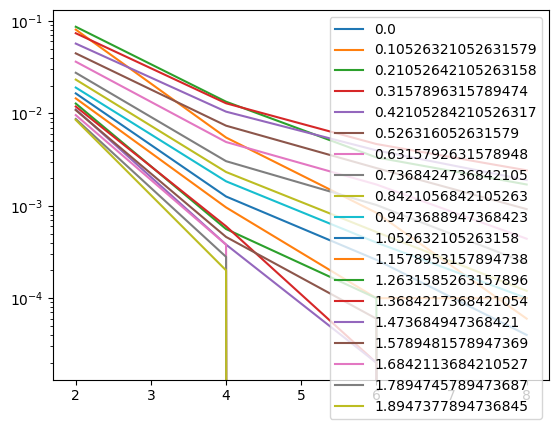

1000 2500 1.5 0.5
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(0).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(1).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(2).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(3).txt
nodes_1000_steps_2500_alpha_3d2_r_1d2_sizes_of_components(4).txt


C:\Users\mique\AppData\Local\Temp\ipykernel_8420\3299428615.py:24: RuntimeWarning: invalid value encountered in divide
  normalized_component_distributions = [component_distributions[step] / component_count[step] for step in range(num_steps)]


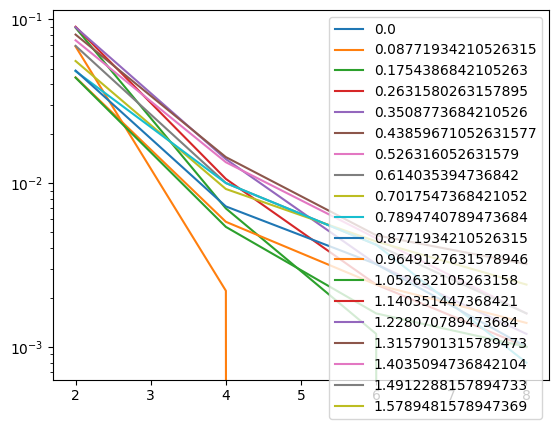

100 1000 2.0 0.5
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(0).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(1).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(10).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(11).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(12).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(13).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(14).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(15).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(16).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(17).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(18).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(19).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(2).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(3).txt
nodes_100_steps_1000_alpha_2d1_r_1d2_sizes_of_components(4).txt
nodes_100_ste

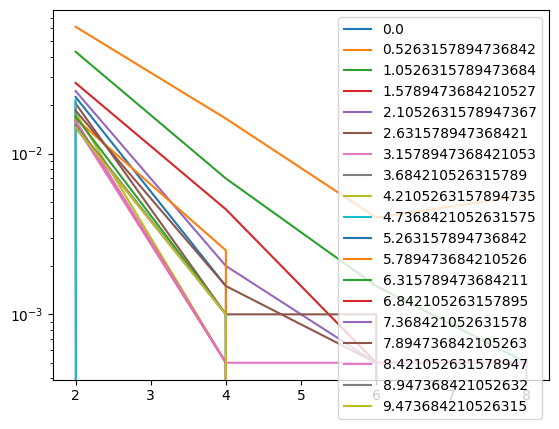

100 200 1.0 0.5
nodes_100_steps_200_alpha_1d1_r_1d2_sizes_of_components(0).txt


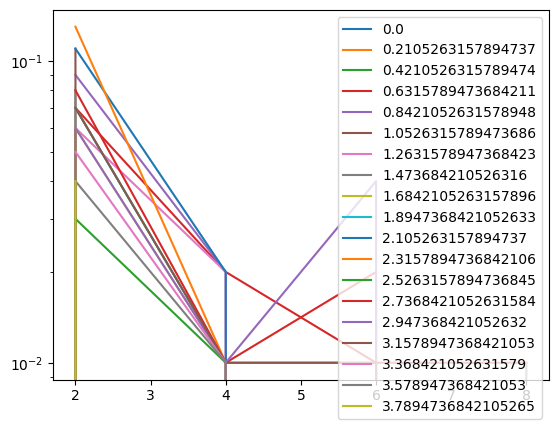

150 500 1.0 0.5
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(0).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(1).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(2).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(3).txt
nodes_150_steps_500_alpha_1d1_r_1d2_sizes_of_components(4).txt


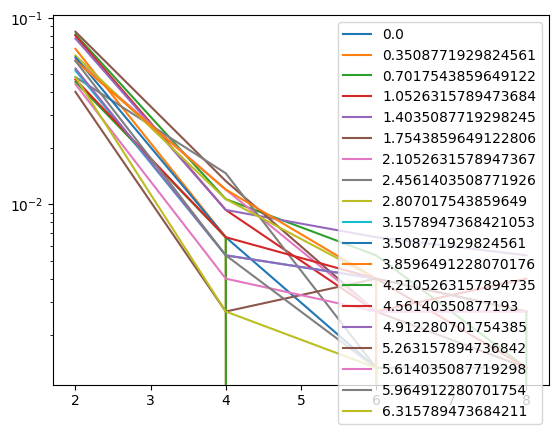

500 1500 2.0 0.25
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(0).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(1).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(2).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(3).txt
nodes_500_steps_1500_alpha_2d1_r_1d4_sizes_of_components(4).txt


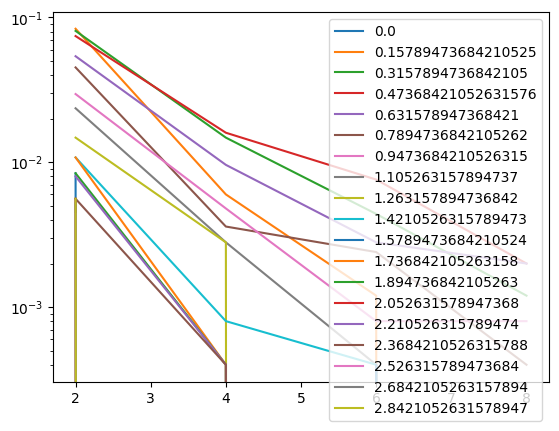

In [55]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    plot_component_distribution_vs_size(prefix=prefix, file_list=file_list)

In [33]:
def plot_u(expected_k_t: float, pk_t: List[float], num_nodes) -> Tuple[List[float], List[float]]:
    u_values, f_u_values = [], []
    for u in range(1000):
        u = u / 1000
        u_values.append(u)
        sum_u = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
        f_u_values.append(sum_u / expected_k_t)

    return u_values, f_u_values

def calculate_u(expected_k_t: float, pk_t: List[float], num_nodes) -> float:

    diff = 0.1  # It just needs to be better than the acceptance threshold
    u = 0.5  # Initial value
    sum_u = 0
    while abs(diff) > 1e-6:
        sum_u = 0
        sum_du = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
            sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
        diff = u - sum_u / expected_k_t
        u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
    print(u, sum_u/expected_k_t, diff)
    return u

0.9999999999999976 0.999999996493727 -1.3454006797530838e-09


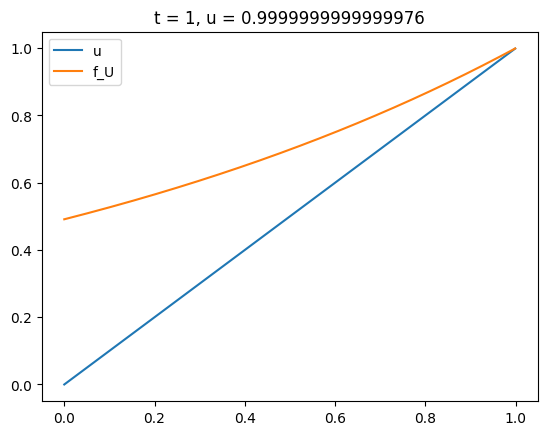

0.8815376611780218 0.8815335025627439 -2.9540039758746417e-07


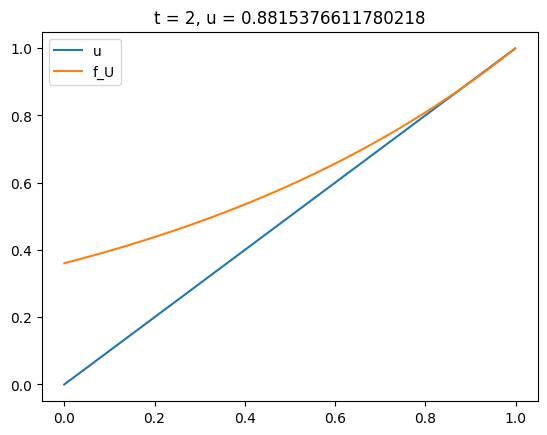

0.685476545797801 0.685476542627344 -7.637502852375633e-10


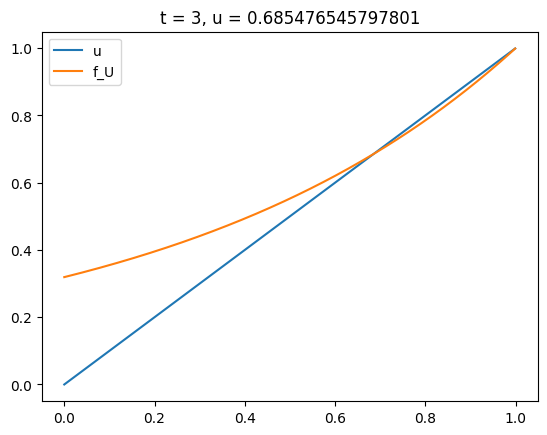

0.6245182010550628 0.6245171550669332 -3.3152263068103593e-07


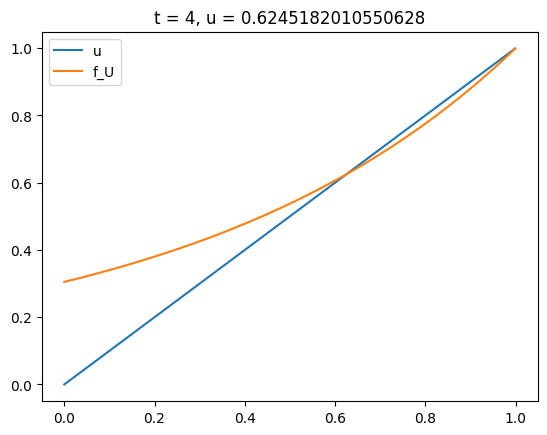

0.60308161419512 0.6030814036681671 -7.329839823988493e-08


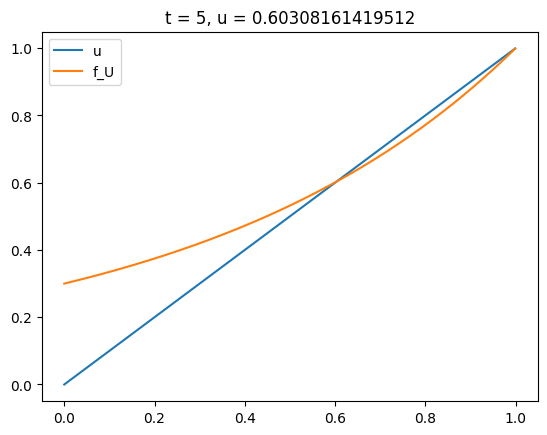

0.59523459174567 0.5952344841957167 -3.8760425424833045e-08


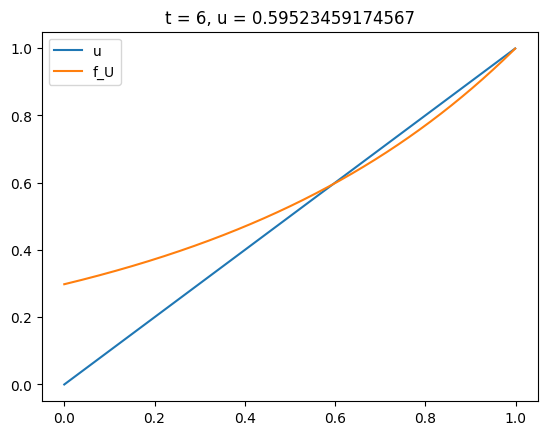

0.5923303505657399 0.5923302678735044 -3.018769290097367e-08


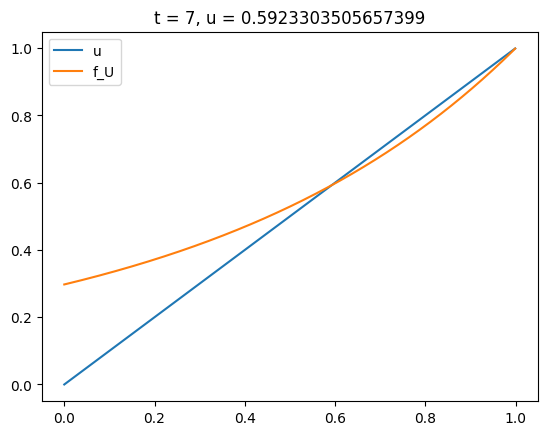

0.591254144559903 0.5912540697042938 -2.7458160523075037e-08


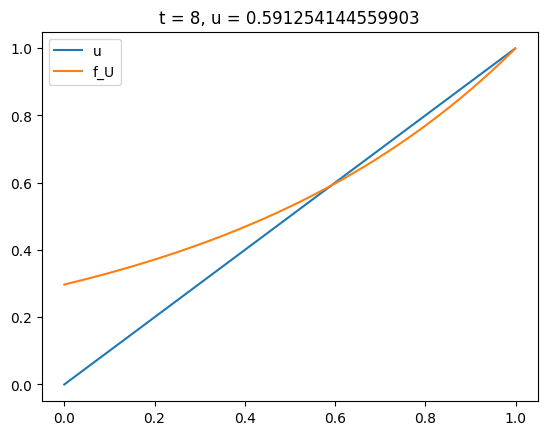

0.5908559210118839 0.5908558488869078 -2.6503676253675224e-08


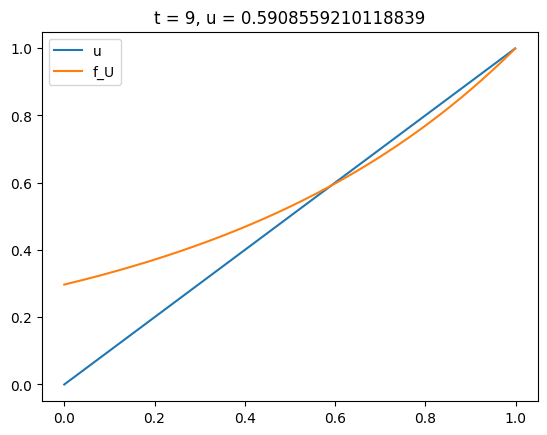

0.5907088258491063 0.5907087547107213 -2.6158378241269986e-08


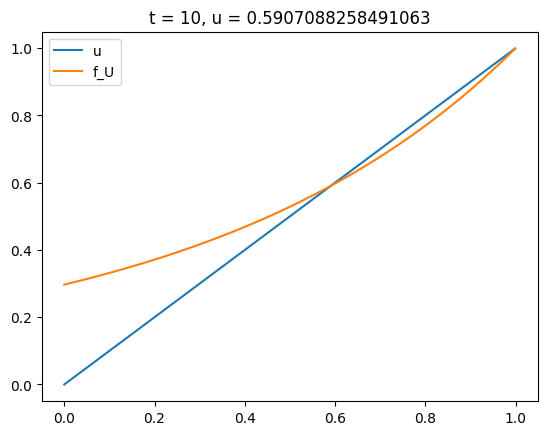

In [34]:
expected_k = expected_k_builder(alpha=1, r=0.5)
pk = pk_builder(alpha=1, r=0.5)

num_nodes = 1000
for t in range(1, 11):
    u, f_u = plot_u(expected_k_t=expected_k(t), pk_t=[pk(k, t) for k in range(num_nodes)], num_nodes=num_nodes)
    plt.title("t = " + str(t) +  ", u = " + str(calculate_u(expected_k_t=expected_k(t), pk_t=[pk(k, t) for k in range(num_nodes)], num_nodes=num_nodes)))
    plt.plot(u, u, label = "u")
    plt.plot(u, f_u, label = "f_U")
    plt.legend()
    plt.show()